# 94889 Preliminary Exercise

## Overview

The purpose of this exercise is to provide a quick check on a couple of the technical skills you'll need in Machine Learning for Public Policy Lab (94-889) anbd help us make sure everyone coming in has the necessary pre-requisites including python, data analysis, databases/sql, and machine learning. 

Feel free to use any references (previous class notes, google, stackoverflow, etc) you would like, but please complete the exercise on your own to ensure the work reflects your experience. **Completing this notebook should take you under 2 hours** -- if you're finding you need to take significantly more time on, you may find it difficult to contribute to the project work in the class.

## Problem Background

This notebook makes use of a sample of the data provided by [DonorsChoose](https://www.donorschoose.org/) to the [2014 KDD Cup](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data). Public schools in the United States face large disparities in funding, often resulting in teachers and staff members filling these gaps by purchasing classroom supplies out of their own pockets. DonorsChoose is an online crowdfunding platform that tries to help alleviate this financial burden on teachers by allowing them to seek funding for projects and resources from the community (projects can include classroom basics like books and markers, larger items like lab equipment or musical instruments, specific experiences like field trips or guest speakers). Projects on DonorsChoose expire after 4 months, and if the target funding level isn't reached, the project receives no funding. Since its launch in 2000, the platform has helped fund over 2 million projects at schools across the US, but about 1/3 of the projects that are posted nevertheless fail to meet their goal and go unfunded.

### The Modeling Problem

For the purposes of this exercise, we'll imagine that DonorsChoose has hired a digital content expert who will review projects and help teachers improve their postings and increase their chances of reaching their funding threshold. Because this individualized review is a labor-intensive process, the digital content expert has time to review and support only 10% of the projects posted to the platform on a given day. 

You are a data scientist working with DonorsChoose, and your task is to help this content expert focus their limited resources on projects that most need the help. As such, you want to build a model to identify projects that are least likely to be fully funded before they expire and pass them off to the digital content expert for review.


# Getting Set Up

Running the code below will create a local postgres 11 database for you and import the sampled donors choose data. Don't worry about the details of that and you shouldn't need to touch any of the code here aside from running it. Below, we'll talk about how to access the database from within the notebook to run queries.

In [2]:
# Install and start postgresql-11 server
!sudo apt-get -y -qq update
!wget --quiet -O - https://www.postgresql.org/media/keys/ACCC4CF8.asc | sudo apt-key add -
!echo "deb http://apt.postgresql.org/pub/repos/apt/ `lsb_release -cs`-pgdg main" |sudo tee  /etc/apt/sources.list.d/pgdg.list
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql-11 postgresql-client-11
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"

# Setup a database with name `donors_choose` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS donors_choose;'

!sudo -u postgres psql -U postgres -c 'CREATE DATABASE donors_choose;'

# Environment variables for connecting to the database
%env DEMO_DATABASE_NAME=donors_choose
%env DEMO_DATABASE_HOST=localhost
%env DEMO_DATABASE_PORT=5432
%env DEMO_DATABASE_USER=postgres
%env DEMO_DATABASE_PASS=postgres

OK
deb http://apt.postgresql.org/pub/repos/apt/ bionic-pgdg main
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 16.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package cron.
(Reading database ... 155680 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128.1ubuntu1.2_amd64.deb ...
Unpacking cron (3.0pl1-128.1ubuntu1.2) ...
Selecting previously unselected package logrotate.
Preparing to unpack .../01-logrotate_3.11.0-0.1ubuntu1_amd64.deb ...
Unpacking logrotate (3.11.0-0.1ubuntu1) ...
Selecting previously unselected package netbase.
Preparing to unpack .../02-netbase_5.4_all

In [3]:
# Download sampled DonorsChoose data and load it into our postgres server
!curl -s -OL https://dsapp-public-data-migrated.s3.us-west-2.amazonaws.com/donors_sampled_20210920_v3.dmp
!PGPASSWORD=$DEMO_DATABASE_PASS pg_restore -h $DEMO_DATABASE_HOST -p $DEMO_DATABASE_PORT -d $DEMO_DATABASE_NAME -U $DEMO_DATABASE_USER -O -j 8 donors_sampled_20210920_v3.dmp

In [4]:
!pip install SQLAlchemy==1.3.18 PyYAML==6.0 psycopg2-binary==2.9.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 60.2 MB/s 
     |████████████████████████████████| 3.0 MB 45.3 MB/s 
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 1.4.39
    Uninstalling SQLAlchemy-1.4.39:
      Successfully uninstalled SQLAlchemy-1.4.39
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [6]:
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine

db_url = URL(
            'postgres',
            host='localhost',
            username='postgres',
            database='donors_choose',
            password='postgres',
            port=5432,
        )

db_engine = create_engine(db_url)

# Querying the Database

The code block above used the `sqlalchemy` module to create a connection to the database called `db_engine`. An easy way to run SQL queries against this database is to use the `read_sql` command provided by `pandas`. For instance, if you run the example below, it should return the number of projects in the sampled dataset (16,480):

In [7]:
pd.read_sql("SELECT COUNT(*) FROM data.projects", db_engine)

,count
0,16480


You can find some more details about the dataset on the [KDD Cup page](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data), but here is a quick description of the four main source tables:
- `data.projects` contains information about each project that was posted on the site, including IDs for the project, school, and teacher, as well as the total amount being requested (note that projects can also request additional "optional support" but don't need to reach this higher bar to be funded)
- `data.essays` has project titles and descriptions
- `data.resources` has information about the specific resources being requested
- `data.donations` contains details about each donation that was received by a project (when it came in, the amount, whether it was from another teacher, etc.)

## Want other packages?
If you need to install any other python modules for your analysis, you can easily do so from a code block by prefixing your `pip install` command with an `!` character. For instance:
```
!pip install PyYAML
```

# QUESTION 1

**(A)** Write a query to return the school id, title, short description, date posted, and total asking price for the most recently posted project from each school in Oregon.

In [8]:
# The query below creates a table view named recent_projects that lists all schools in OR and their most recent project (ranked 1). 
# This table is then joined with other tables to give final output
# A school can have more than one recent project (posted on the same date) in which case both appear in the table


query_1 = """
WITH recent_projects AS (
  SELECT RP.projectid_str, RP.schoolid, RP.date_posted, RP.total_asking_price	
  FROM (SELECT p.projectid_str, p.schoolid, p.date_posted, p.total_asking_price	, RANK() OVER(PARTITION BY p.schoolid ORDER BY p.date_posted DESC) AS rank
    FROM data.projects p
    WHERE p.school_state = 'OR'
    ORDER BY p.schoolid) RP
  WHERE RP.rank = 1
)


SELECT p.schoolid, e.title, e.short_description, p.date_posted, p.total_asking_price	
FROM recent_projects p JOIN data.essays e ON (p.projectid_str = e.projectid_str) 
ORDER BY p.schoolid;
"""

pd.read_sql(query_1, db_engine)

,schoolid,title,short_description,date_posted,total_asking_price
0,13389ac5a646c1d7b68678bba13878a5,Owl Be Learning About the Foodchain,Do you remember what it was like when you did ...,2011-10-30,154.40
1,16c2e091c46696b6af2321a68fc9f53a,iPad Differentiation!,Do you remember the first time you had the abi...,2013-10-06,1665.96
2,28af7a22c4a224d9450b9b7aee7261e7,Lifting Our Way to a Healthier Day,My students are looking for new ways to build ...,2011-11-13,598.57
3,2f53c699c8a0f2154f36ce325e4fa9ea,Get in Touch (with Your Senses),"Sensory input is such a major part of our day,...",2014-03-01,297.95
4,2fb6bd29ba665d9e98727a52753477c5,Recycling Project,"Robert Alanr said, ""We can help educate our fa...",2011-02-15,495.59
5,36cfae1eee5bc4679300fe2bf0bab812,Communism vs Capitalism: An Examination of Ani...,Our students live in a former timber town and ...,2012-09-17,318.97
6,5d01b7ac5916d47cbc22bf93ba9c814d,Class Set of Young Adult Novels,Students in my diversely populated high povert...,2013-10-17,651.33
7,786c1ac1f4e18ff2a1a25b7f4f7bdc8a,Art Through the Curriculum,Writing is an integral part of our day. We wri...,2014-05-04,136.43
8,8cb0ace5cc80e2082c1bcd2f1805bdcf,Agents of Change,"As a small school, we do not have the luxury o...",2012-01-01,139.95
9,a942c6c1756f362660a4f3e9f694bb92,Population Diversity Survey-Raptor County,The students in environmental science will par...,2010-09-19,605.24


**(B)** Create a scatter plot of the number of resources requested vs fraction of the total ask amount that was funded across all projects in New Hampshire. (Hint: You'll need to join a couple of tables here to figure out the amount donated to a project)

Text(0, 0.5, 'Fraction of Asking Price Funded')

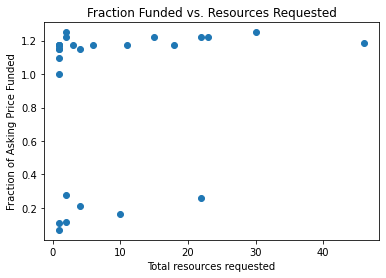

In [36]:
# The query below creates two table views named total_donations and total_resources and then joins them with projects
# Here the number of resources requested by a project is calculated by taking the project-wise sum of item_quantity in resources
# Here the total donation to a project is calculated by taking the project-wise sum of donation_total in donations


query_2 = """
WITH total_donations AS(
  SELECT d.projectid_str, SUM(d.donation_total) AS total_donated
  FROM data.donations d
  GROUP BY d.projectid_str
),

  total_resources AS(
  SELECT r.projectid_str, SUM(r.item_quantity) AS num_resources
  FROM data.resources r
  GROUP BY r.projectid_str
)

SELECT p.projectid_str, tr.num_resources, td.total_donated, p.total_asking_price, td.total_donated/p.total_asking_price AS fraction_funded
FROM data.projects p JOIN total_resources tr ON(p.projectid_str = tr.projectid_str) JOIN total_donations td ON(p.projectid_str = td.projectid_str)
WHERE p.school_state = 'NH'
"""

request_vs_fund = pd.read_sql(query_2, db_engine)

import matplotlib.pyplot as plt
plt.scatter(request_vs_fund['num_resources'],request_vs_fund['fraction_funded'])
plt.title('Fraction Funded vs. Resources Requested')
plt.xlabel('Total resources requested')
plt.ylabel('Fraction of Asking Price Funded')



# QUESTION 2

For this question, you'll develop a model to help DonorsChoose identify 10% of projects to have their digital content expert review based on their risk of failing to reach their funding goal. In order to intervene early in the process, DonorsChoose wants to identify these projects to help immediately upon being posted to the site.

Build and evaluate the performance of a handful of machine learning models. **Be sure to use comments or text blocks to discuss the choices and assumptions you're making along the way.** Note that you don't need to explore an extensive model space here -- building 3 or 4 models should be fine for the purposes of this exercise. Feel free to use any python packages available (such as sklearn) for this.



---



Since DonorsChoose wants to identify potentially underfunded projects early on, it needs to make risk predictions using information available immediately, once the project is posted. This means it can use data on project characteristics (projects and essays data)and the type of resources a project requests (resources data). 

We assume that at the time a project is posted, DonorsChoose does not have access to any variables in the 'donations' and the 'outcomes' data. The outcomes data has a variable called 'fully funded' which indicates whether a project achieved its funding goal and was succesfully completed. We will use this ground truth labeled variable to train a supervised machine learning model that predicts whether a project will be funded.

In [10]:
#### Setting up the input data ####
'''
Project attributes and resources - projects is joined with essays and resources to get project attributes like project location, project's school details,
project title and total quantity of items requested in one dataframe
'''

# Creating a query for relevant data
query_4 = ''' 
WITH total_resources AS(
  SELECT r.projectid_str, SUM(r.item_quantity) AS num_resources
  FROM data.resources r
  GROUP BY r.projectid_str
  ),
essays AS (
  SELECT e.projectid_str, e.title
  FROM data.essays e
  )
SELECT *
FROM data.projects p JOIN essays e USING (projectid_str) JOIN total_resources tr USING (projectid_str);

'''

# Creating project_features dataframe
features = pd.read_sql(query_4, db_engine)

# Removing irrelevant columns 
'''
IDS by themselves don't convey any information and location details such city and county, focus areas, grades etc. are omitted for this exercise as they may create 
too many categorical variables
'''
features.drop(columns=['schoolid','teacher_acctid', 'school_ncesid','school_latitude', 'school_longitude', 'school_city',
                       'school_zip', 'school_metro', 'school_district', 'school_county', 'teacher_prefix',
                       'primary_focus_subject','secondary_focus_subject', 'secondary_focus_area', 'resource_type',
                       'grade_level', 'fulfillment_labor_materials','date_posted', 'entity_id'], axis=1, inplace=True)

# Creating outcome dataframe
outcomes = pd.read_sql('SELECT o.projectid_str, o.fully_funded FROM data.outcomes o', db_engine)

# Merging features and outcomes data 

merged_data = pd.merge(features, outcomes, on = 'projectid_str')

merged_data




,projectid_str,school_state,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_teach_for_america,teacher_ny_teaching_fellow,primary_focus_area,poverty_level,total_asking_price,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,title,num_resources,fully_funded
0,0000fa3aa8f6649abab23615b546016d,CA,False,False,True,False,False,False,False,False,History & Civics,highest poverty,240.10,282.47,28,True,False,Innovative Lessons On Civil Rights And Diversity,35.0,True
1,00039d3650a7c39ce6d2af7ad19b0a4f,NC,False,False,False,False,False,False,False,False,Math & Science,high poverty,264.31,303.80,24,True,False,Little Creatures,4.0,False
2,0006a31d45f8d52d217e7c5b55c11f37,ME,False,False,False,False,False,False,False,False,Applied Learning,high poverty,712.94,838.75,25,False,False,Engaging Classroom Technology,1.0,True
3,000bf12405c7af331dfaf0af72ca179d,NY,False,False,False,False,False,False,False,False,Literacy & Language,high poverty,250.42,294.61,98,False,False,The Lost Art Of Thank You,53.0,True
4,000faa31e276e9e649360949207fa00c,MO,False,False,False,False,False,False,False,False,Literacy & Language,high poverty,537.31,632.13,25,False,False,Helping Military Students Become Great Readers,3.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15231,ffdfc7564e7a1cc3d4009c4abf8f0dfe,CA,False,False,False,False,False,False,False,False,Literacy & Language,highest poverty,332.00,404.88,20,False,False,Dictionary that Talks!,5.0,True
15232,ffe5521afd0bc45ad5c560d6e6d300ab,TX,False,False,False,False,False,False,False,False,Literacy & Language,highest poverty,135.68,159.62,75,False,False,Real Life Drama: Non-fiction,12.0,True
15233,ffe9dc323dcb8403e4e34d965e7cda37,NY,False,False,True,False,False,False,False,False,Special Needs,high poverty,462.00,563.41,6,False,False,New Teacher: Running Out Of Money!,17.0,False
15234,fff2173cd82bd5bfd255a33018cdf87e,WI,False,False,False,False,False,False,False,False,Special Needs,moderate poverty,133.00,162.20,10,False,False,Recorded Books for Special Education Students,3.0,True


Now that we have merged the datasets, let's take a look at how much data is missing.

In [11]:
# Getting proportion of missing values in every attribute
merged_data.isnull().sum()/ len(merged_data)


projectid_str                             0.000000
school_state                              0.000000
school_charter                            0.000000
school_magnet                             0.000000
school_year_round                         0.000000
school_nlns                               0.000000
school_kipp                               0.000000
school_charter_ready_promise              0.000000
teacher_teach_for_america                 0.000000
teacher_ny_teaching_fellow                0.000000
primary_focus_area                        0.000000
poverty_level                             0.000000
total_asking_price                        0.000000
total_price_including_optional_support    0.000000
students_reached                          0.000000
eligible_double_your_impact_match         0.000000
eligible_almost_home_match                0.000000
title                                     0.000000
num_resources                             0.013324
fully_funded                   

Since the projects with missing values in the 'num_resources' variable is merely 1.3% of the total observations, we drop these.

In [12]:
merged_data.dropna(inplace=True)
print(f'There are {len(merged_data)} rows in the data now.')

There are 15033 rows in the data now.


In [13]:
# Separating predicted variable from predictors 
y = merged_data['fully_funded']

X = merged_data.drop(columns=['projectid_str', 'fully_funded'], axis = 1)

Our data has a number of categorical variables such as school_state, school_charter, poverty_level etc. While most of these are binary (boolean) variables, some of them have more than two categories. Converting such variables into dummy variables may create too many variables and potentially sparse data. Therefore, it may be wise to check the number of categories in every variable.

In [14]:
X.nunique(axis=0)

school_state                                 50
school_charter                                2
school_magnet                                 2
school_year_round                             2
school_nlns                                   2
school_kipp                                   2
school_charter_ready_promise                  2
teacher_teach_for_america                     2
teacher_ny_teaching_fellow                    2
primary_focus_area                            7
poverty_level                                 4
total_asking_price                        11275
total_price_including_optional_support    11356
students_reached                            356
eligible_double_your_impact_match             2
eligible_almost_home_match                    2
title                                     14470
num_resources                               212
dtype: int64

Looks like the categorical variable with the most number of categories is state.

In [15]:
# Creating a list of categorical variables
categorical_features = list(X.columns[X.nunique(axis=0)<=50])
categorical_features

['school_state',
 'school_charter',
 'school_magnet',
 'school_year_round',
 'school_nlns',
 'school_kipp',
 'school_charter_ready_promise',
 'teacher_teach_for_america',
 'teacher_ny_teaching_fellow',
 'primary_focus_area',
 'poverty_level',
 'eligible_double_your_impact_match',
 'eligible_almost_home_match']

In [16]:
# Creating dummy variables out of categorical variables
X = pd.get_dummies(X, columns = categorical_features, drop_first = True)
X.head(5)

,total_asking_price,total_price_including_optional_support,students_reached,title,num_resources,school_state_AL,school_state_AR,school_state_AZ,school_state_CA,school_state_CO,school_state_CT,school_state_DC,school_state_DE,school_state_FL,school_state_GA,school_state_HI,school_state_IA,school_state_ID,school_state_IL,school_state_IN,school_state_KS,school_state_KY,school_state_LA,school_state_MA,school_state_MD,school_state_ME,school_state_MI,school_state_MN,school_state_MO,school_state_MS,school_state_MT,school_state_NC,school_state_NE,school_state_NH,school_state_NJ,school_state_NM,school_state_NV,school_state_NY,school_state_OH,school_state_OK,school_state_OR,school_state_PA,school_state_RI,school_state_SC,school_state_SD,school_state_TN,school_state_TX,school_state_UT,school_state_VA,school_state_VT,school_state_WA,school_state_WI,school_state_WV,school_state_WY,school_charter_True,school_magnet_True,school_year_round_True,school_nlns_True,school_kipp_True,school_charter_ready_promise_True,teacher_teach_for_america_True,teacher_ny_teaching_fellow_True,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,eligible_double_your_impact_match_True,eligible_almost_home_match_True
0,240.10,282.47,28,Innovative Lessons On Civil Rights And Diversity,35.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
1,264.31,303.80,24,Little Creatures,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,712.94,838.75,25,Engaging Classroom Technology,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,250.42,294.61,98,The Lost Art Of Thank You,53.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,537.31,632.13,25,Helping Military Students Become Great Readers,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Next, we make our set of features richer by extracting features from the 'title' column. These include the number of words, number of prepositions (stop words), capital words etc. in the project title. The way a project title is structured may be a good predictor of how attractive the project is and thus, whether it gets funding. 

(A similar step can be done for the need statement, but is not done here.)

In [17]:

#### Feature engineering from project titles ####

# Defining various functions for word count, punctuation count etc.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


import re

def count_chars(text):
    return len(text)

def count_words(text):
    return len(text.split())

def count_capital_chars(text):
    count=0
    for i in text:
        if i.isupper():
            count+=1
    return count

def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

def count_punctuations(text):
    punctuations='''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'''
    d=dict()
    for i in punctuations:
        d[str(i)+' count']=text.count(i)
    return d 
    
def count_words_in_quotes(text):
    x = re.findall(''''.'|"."''', text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

def count_sent(text):
    return len(nltk.sent_tokenize(text))

def count_unique_words(text):
    return len(set(text.split()))

def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = nltk.word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [18]:
X['char_count'] = X['title'].apply(lambda i:count_chars(i))
X['word_count'] = X['title'].apply(lambda i:count_words(i))
X['sent_count'] = X['title'].apply(lambda i:count_sent(i))
X['capital_char_count'] = X['title'].apply(lambda i:count_capital_chars(i))
X['capital_word_count'] = X['title'].apply(lambda i:count_capital_words(i))
X['quoted_word_count'] = X['title'].apply(lambda i:count_words_in_quotes(i))
X['unique_word_count'] = X['title'].apply(lambda i:count_unique_words(i))
X['stopword_count'] = X['title'].apply(lambda i:count_stopwords(i))

In [19]:
# Removing title column from X
X.drop(columns= ['title'], axis=1, inplace = True)

# Storing feature names for later use
feature_names = list(X.columns)

For the purpose of training models through sklearn, we store the predictor and predicted variables in numpy arrays.

---



In [20]:
import numpy as np

# Transforming dataframes into arrays
y = np.array(y) 

X = np.array(X)

In [21]:
# Checking for class distribution in labeled output y
distribution = np.unique(y, return_counts=True)
print(f'As expected, {round((distribution[1][1]/len(y))*100,1)}% of the projects are funded in this data, i.e. it is an imbalanced data set')

As expected, 69.1% of the projects are funded in this data, i.e. it is an imbalanced data set


While training ML models, it is good practice to standardize variables as it prevents the units of predictors from having undue influence on the model (especially relevant for regularization).

In [22]:
# Standardizing data (in order to remove the influence of units or scale of predictors on the model) 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

print(X)

from sklearn.model_selection import train_test_split

# Dividing intro training and testing datasets, with a 30-70 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 5)

[[-0.46126064 -0.46294192 -0.01581333 ... -0.0182404   0.90229285
  -0.73787246]
 [-0.41967898 -0.4322975  -0.01630375 ... -0.0182404  -1.37970048
  -0.73787246]
 [ 0.35086147  0.33625535 -0.01618114 ... -0.0182404  -0.92330182
  -0.73787246]
 ...
 [-0.08013828 -0.05932057 -0.01851066 ... -0.0182404   0.44589418
  -0.73787246]
 [-0.64520929 -0.63573162 -0.01802023 ... -0.0182404   0.44589418
   0.38541227]
 [-0.38958766 -0.39241521 -0.01630375 ... -0.0182404  -0.46690315
   1.50869699]]


Before training models, we create a function that gives various model metrics to quantify the quality of a model's predictions. Since we are trying to solve a classification problem, the function returns accuracy, precision in predicting funding and no-funding, sensitivity, specificity, F1-score and area under ROC curve.

In [23]:
#Creating function to evaluate models and return metrics

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import seaborn as sns

def evalClassModel(model, y_test, y_pred_test):
    
    #Confusion matrix
        
    # save confusion matrix and slice into four pieces
    confusion = confusion_matrix(y_test, y_pred_test)
    #[row, column]
    TP = confusion[1, 1] # True Positives (Actually funded)
    TN = confusion[0, 0] # True Negatives (Actually not-funded)
    FP = confusion[0, 1] # False Positives (Actually not-funded, but predicted funded )
    FN = confusion[1, 0] # False Negatives (Actually funded, but predicted not-funded )
       
    #Accuracy: (TP + TN)/(TP + TN + FP + FN)
    accuracy = accuracy_score(y_test, y_pred_test)

    #Precision_funded: TP/(TP + FP)
    precision_funded = precision_score(y_test, y_pred_test)
    
    #Precision_funded: TN/(TN + FN)
    precision_not_funded = precision_score(np.logical_not(y_test), np.logical_not(y_pred_test))

    #Recall/Sensitivity/True Positive Rate: TP/(TP + FN)
    sensitivity = recall_score(y_test, y_pred_test)
 
    #Specificity/True Negative Rate: TN/(TN + FP) 
    specificity = recall_score(np.logical_not(y_test) , np.logical_not(y_pred_test))

    #F1 Score: 2*(Precision*Recall)/(Precision + Recall)
    f1 = f1_score(y_test, y_pred_test)
    
    #ROC Score: Area under the ROC
    roc = roc_auc_score(y_test, y_pred_test)
 
    return({'accuracy':accuracy, 'precision_funded':precision_funded, 'precision_not_funded':precision_not_funded,
            'sensitivity':sensitivity, 'specificity':specificity, 'f1':f1, 'roc':roc})



Next we try to train a number of classification models. We begin with the simplest- a Naive Bayes classifier, then try a logistic model, a boosted logistic model, a decision tree, a random forest, a gradient boosted classifier and finally a support vector classifier.

While a number of other models can be explored, for the purpose of this exercise we train a number of common classifiers and look at a few ensemble methods. When it comes to improving predictions, ensemble methods like adaptive boosting, random forests and gradient boosting work particularly well as they combine predictions from several models.

Please note that the hyper-parameter values used in training the following models have been based on an educated guess. The predictions may improve drastically if model hyper-parameters are tuned based on a parameter grid search.

In [24]:
# Naive Bayes

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB().fit(X_train, y_train)
nb_pred = nb.predict(X_test)
nb_metrics = evalClassModel(nb, y_test, nb_pred)

In [25]:
# Logistic Model

from sklearn.linear_model import LogisticRegressionCV
logreg = LogisticRegressionCV(cv=10,penalty = 'l2', max_iter = 500, random_state = 5)
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_metrics = evalClassModel(logreg, y_test, logreg_pred)


In [26]:
# AdaBoost Logistic Model 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
logreg_boost = AdaBoostClassifier(base_estimator = LogisticRegression(penalty = 'l2'),
                                  n_estimators=30, learning_rate=0.01, random_state=5)
logreg_boost.fit(X_train, y_train)
logreg_boost_pred = logreg_boost.predict(X_test)
logreg_boost_metrics = evalClassModel(logreg_boost, y_test, logreg_boost_pred)


In [27]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth = 30, random_state=5)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_metrics = evalClassModel(dt, y_test, dt_pred)


In [28]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=50, random_state=5)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_metrics = evalClassModel(rf, y_test, rf_pred)


In [29]:
# Gradient Boosting Classifier

from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=30, learning_rate=0.1, max_depth=10, random_state=5)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_metrics = evalClassModel(gb, y_test, gb_pred)

In [30]:
# Support Vector Classifier

from sklearn.svm import SVC
sv = SVC(gamma='auto')
sv.fit(X_train, y_train)
sv_pred = sv.predict(X_test)
sv_metrics = evalClassModel(sv, y_test, sv_pred)

In [31]:
# Evaluating models based on classification metrics on the test data

model_metrics = pd.DataFrame({'Model':["Naive Bayes", "Logistic Regression", "AdaBoost Logistic Regression","Decision Tree", 
                                       "Random Forest Classifier", "Gradient Boosting Classifier", "Support Vector Classifier"],
                              'Accuracy':[nb_metrics['accuracy'], logreg_metrics['accuracy'], logreg_boost_metrics['accuracy'], dt_metrics['accuracy'],
                                         rf_metrics['accuracy'], gb_metrics['accuracy'], sv_metrics['accuracy']],
                              'Precision_Funded':[nb_metrics['precision_funded'], logreg_metrics['precision_funded'], logreg_boost_metrics['precision_funded'], dt_metrics['precision_funded'],
                                         rf_metrics['precision_funded'], gb_metrics['precision_funded'], sv_metrics['precision_funded']],
                              'Precision_Not_Funded': [nb_metrics['precision_not_funded'], logreg_metrics['precision_not_funded'], logreg_boost_metrics['precision_not_funded'], dt_metrics['precision_not_funded'],
                                         rf_metrics['precision_not_funded'], gb_metrics['precision_not_funded'], sv_metrics['precision_not_funded']],
                              'Sensitivity':[nb_metrics['sensitivity'], logreg_metrics['sensitivity'], logreg_boost_metrics['sensitivity'], dt_metrics['sensitivity'],
                                         rf_metrics['sensitivity'], gb_metrics['sensitivity'], sv_metrics['sensitivity']],
                              'Specificity': [nb_metrics['specificity'], logreg_metrics['specificity'], logreg_boost_metrics['specificity'], dt_metrics['specificity'],
                                         rf_metrics['specificity'], gb_metrics['specificity'], sv_metrics['specificity']],
                              'F1-Score': [nb_metrics['f1'], logreg_metrics['f1'], logreg_boost_metrics['f1'], dt_metrics['f1'],
                                         rf_metrics['f1'], gb_metrics['f1'], sv_metrics['f1']],
                              'Area under ROC':[nb_metrics['roc'], logreg_metrics['roc'], logreg_boost_metrics['roc'], dt_metrics['roc'],
                                         rf_metrics['roc'], gb_metrics['roc'], sv_metrics['roc']]})
model_metrics


,Model,Accuracy,Precision_Funded,Precision_Not_Funded,Sensitivity,Specificity,F1-Score,Area under ROC
0,Naive Bayes,0.681818,0.710292,0.354571,0.926730,0.096241,0.804202,0.511485
1,Logistic Regression,0.709756,0.726021,0.528302,0.944969,0.147368,0.821150,0.546168
2,AdaBoost Logistic Regression,0.706430,0.706498,0.687500,0.998428,0.008271,0.827469,0.503349
3,Decision Tree,0.645898,0.753930,0.404164,0.738994,0.423308,0.746387,0.581151
4,Random Forest Classifier,0.721951,0.752094,0.555072,0.903459,0.287970,0.820857,0.595715
5,Gradient Boosting Classifier,0.711308,0.744786,0.520772,0.898428,0.263910,0.814424,0.581169
6,Support Vector Classifier,0.709978,0.717776,0.551887,0.970126,0.087970,0.825087,0.529048


Since we need to find a model that performs well in identifying projects that are at high risk of being underfunded, the metrics we should prioritize are precision of not being funded and specificity. Precision of not being funded means that among all projects predicted to be underfunded, how many will be truly underfunded. While specificity means that among all projects that are actually underfunded, how many are predicted to be underfunded.

Given the problem at hand, 10% of the projects predicted to be at highest risk of being underfunded will be reviewed by the digital content expert. As a result, more precision (of not being funded) means greater chance that time is spent on projects that actually need review. A higher specificity means a higher fraction of projects that actually needed help were reviewed. Since reviewing projects is labor and time intensive, DonorChoose would not want to spend time on projects which don't need help. Therefore, higher precision may be preferred over specificity even if it comes at a cost of omitting review of some projects that actually need help.

**Since the adaboost logistic classifier performs the best in terms of precision of not being funded, we base our predictions on it.**

Please note, most of these models don't achieve a very high precision in identifying underfunded projects. The area under ROC measure suggests that most of them are not great at distinguishing classes. However, these models might improve significantly with better feature engineering, more balanced data, extensive hyper-parameter tuning and inclusion of other project characteristics.

In [32]:
# Identifying projects at a higher risk of not reaching their funding goals

predicted_prob = pd.DataFrame(logreg_boost.predict_proba(X), columns=['Pr(No funding)', 'Pr(Funding)'])

predicted_prob = predicted_prob.set_index(merged_data.index)

final_output = pd.merge(merged_data['projectid_str'], predicted_prob , left_index=True, right_index=True)

# Projects for which the probability of no funding is greater than 50%
final_output.loc[final_output['Pr(No funding)']> 0.5].sort_values(by = 'Pr(No funding)', ascending = False)



,projectid_str,Pr(No funding),Pr(Funding)
5528,5d78043c5ae98c2333d58a7d8edb0e50,0.967164,0.032836
8663,921171035c607d20d108f544a88286ed,0.868141,0.131859
10745,b481c42a3441d35a545f4813fadf8a8b,0.868026,0.131974
10499,b022a5d77a9e8e21f0c0efe7995104ec,0.811001,0.188999
7548,7f790887fb3815d7fed75cfd917b52b1,0.808360,0.191640
15035,fcb1215f607107f491bd6266ba16d972,0.751472,0.248528
1767,1d82ff982bb2d345259a9b980b93b861,0.751472,0.248528
7607,809df529ef17e10a2785030a945cadc9,0.744510,0.255490
10056,a93935513f02054de6a2211b722e6677,0.729162,0.270838
9148,99b9c0568cbf636786af0a79146b2ade,0.715173,0.284827


To get a sense of which predictors are important in predicting a project's risk of not achieving its funding goal, we find features with high absolute values of coefficients (greater than average). 

In [33]:
# Displaying features which are more important in terms of absolute value of their coefficients
from sklearn.feature_selection import SelectFromModel

imp_feat = SelectFromModel(logreg, prefit = True, threshold = 'mean') # threshold for selection is the mean value of feature importances

imp_index = imp_feat.get_support()

imp_feature_table = pd.DataFrame({'important predictors':feature_names, 'coefficients': list(logreg.coef_[0])})[imp_index]

print(f'There are {len(imp_feature_table)} important features')

imp_feature_table 

There are 26 important features


,important predictors,coefficients
0,total_asking_price,0.163499
1,total_price_including_optional_support,-0.788914
2,students_reached,-0.123539
7,school_state_CA,0.070195
12,school_state_FL,-0.146301
13,school_state_GA,-0.078924
21,school_state_LA,-0.101461
30,school_state_NC,-0.103511
38,school_state_OK,-0.068015
42,school_state_SC,-0.104468


The above table shows that the total resources requested by a project (fund amount as well as number of items), the outreach of a project, the state a school is situated in, poverty level of a school and the way the project is titled - all are important predictors of whether a project will achieve its funding goal.

# Question 3

Write a one-paragraph discussion of your results for a non-technical decision-maker with any recommendations for deployment or next steps.


DonorsChoose needs to predict projects' risk of not receiving funding, using information available to it at the time a project is posted. This can be done by building a machine learning model based on historical data of project attributes and the ground truth about funding status. In this exercise, we do so by using the datasets 'projects', 'essays', 'resources' and 'outcomes'.  While evaluating various models, we use several metrics such as accuracy and precision. Based on the context of this problem, the chosen model performed best in terms of precision - fraction of the projects predicted at risk which actually did not get funded. The model takes project attributes as input and gives funding probability as output. Based on this, projects at the highest-risk of not being funded can be identified. As expected, the model suggests that the amount of resources a project requests, its student outreach, school location, school's poverty level etc. are important predictors of funding probability. But interestingly, the model also shows that certain finer aspects of the project such as the capital character count of its title, whether it was eligible for a 50% off offer by a corporate partner and if the associated teacher is a Teach for America (TFA) member, are also important in predicting funding. Thus, the project reviewer could recommend reframing project titles, involving faculty associated with establisted non-profits and partnering with corporate companies to attract more funding. It also seems like certain project areas like music, arts, math and science have higher chances of getting funded. Therefore, making sure that project descriptions highlight these areas adequately, can be an effective step.







# Submission

To submit your exercise, please **save a copy** of this notebook containing your code and outputs (you can save it either to google drive or github, but make sure the course staff will have read permissions to access it).

Include a link to your copy of the notebook when you fill out [this survey](https://datascience.wufoo.com/forms/z17mvha70usjfv7/) along with your other details.

Thank you and we're looking forward to a great semester in 94889!